# ABIDE Subtype analysis

In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import nilearn as nil
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import linear_model as slin
from statsmodels.sandbox import stats as sts
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.sandbox.stats import multicomp as smi

In [2]:
%matplotlib inline

# Paths

In [3]:
# Paths
scale = 12
name = 'n308_sample'
mtp_list= ['rmap_part', 'dual_regression', 'stability_maps']
mtp = mtp_list[2]

in_default = '{}_{}_scale_{:03d}'.format(mtp, name, scale)

prior_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale{:03d}.nii.gz'.format(scale)
pheno_path = '/data1/abide/Pheno/unconstrained_2box_308_sample.csv'
in_path = '/data1/subtypes/serial_preps/'

netstack_path = os.path.join(in_path, 'netstack_raw_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
netraw_path = os.path.join(in_path, 'netstack_dmn_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
corrmat_path = os.path.join(in_path, 'correlation_matrix_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))

mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'

In [4]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0

In [5]:
# Get the phenotype data
pheno = pd.read_csv(pheno_path)

In [6]:
# add coded variable for ratio of VIQ and PIQ
pheno['VerbRatio'] = pheno['VIQ'] / pheno['PIQ']

In [7]:
# Get the prior
p_img = nib.load(prior_path)
prior = p_img.get_data()

In [8]:
# Turn the priors into an image
prior = nib.load(prior_path)
prior_data = prior.get_data()
prior_temp = np.zeros((prior_data.shape + (scale,)))
for sc_id in range(scale):
    tmp = np.zeros_like(prior_data)
    tmp[prior_data==sc_id+1] = sc_id + 1
    prior_temp[..., sc_id] = tmp
prior_img = nib.Nifti1Image(prior_temp, affine=m_img.get_affine(), header=m_img.get_header())

# Define some functions and the niak colormap

In [9]:
# Define a new colormap
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 1.0, 1.0),
                   (0.25, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.25, 1.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
hotcold = LinearSegmentedColormap('hotcold', cdict)

## Build the subtypes and compute the weights

In [10]:
# Load the serialized netstack
netstack = np.load(netstack_path)
corr_mat = np.load(corrmat_path)

In [11]:
# Make the grand average
gdavg = np.zeros(mask.shape + (scale,))

In [12]:
netraw = np.load(netraw_path)

In [13]:
cov_list = ['FIQ', 'VIQ', 'PIQ', 'ADI_R_SOCIAL_TOTAL_A',
            'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 
            'VINELAND_ABC_STANDARD', 'ADOS_TOTAL', 'SRS_RAW_TOTAL', 'DX_GROUP']
inv_list = ['VIQ',  'ADOS_TOTAL', 'DX_GROUP']
subtypes = 5

scale = netstack.shape[0]
n_sub = netstack.shape[2]
n_vox = netstack.shape[1]

link_store = np.zeros((n_sub-1,4,scale))
part_store = np.zeros((scale, n_sub))
sbt_store = np.zeros((scale, subtypes, n_vox))
weight_store = np.zeros((scale, subtypes, n_sub))

# Iterate through the networks
for net_id in range(scale):
    # Compute linkage with Ward's criterion
    link_mat = scl.hierarchy.linkage(corr_mat[net_id, ...] , method='ward')
    link_store[..., net_id] = link_mat
    # Partition the linkage to get a given number of subtypes
    part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')
    part_store[net_id, :] = part_sub

    sub_stack = np.zeros((n_vox, subtypes))
    for s_id in range(subtypes):
        sbt = np.mean(netstack[net_id, :, part_sub==s_id+1],0)
        sub_stack[:,s_id] = sbt
        sbt_store[net_id, s_id, :] = sbt

    # Init store - Compute the weights
    for s_id in range(subtypes):
        type_map = sub_stack[:, s_id]
        weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])

    # Init store - Compute the weights
    for s_id in range(subtypes):
        type_map = sub_stack[:, s_id]
        weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])

In [14]:
# Reduce the phenotype data to those subjects 
# that actually have the covariate of interest
cov_list = ['FIQ', 'VIQ', 'PIQ', 'ADI_R_SOCIAL_TOTAL_A',
            'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 
            'VINELAND_ABC_STANDARD', 'ADOS_TOTAL', 'SRS_RAW_TOTAL', 'DX_GROUP']
cov = cov_list[-3]
cov_index = pd.notnull(pheno.replace(-9999, np.nan)[cov])

In [15]:
print('{} has {}'.format(cov, np.sum(cov_index)))

ADOS_TOTAL has 136


In [16]:
cov_pheno = pheno[cov_index]
# Generate the model matrix
factors = [cov, 'SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
# Make dummy variables for the site factor
site_factor = pd.get_dummies(cov_pheno['SITE_ID'])
# Turn the first site into the intercept
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = cov_pheno.ix[:,factors]
# Turn diagnosis into [0,1] vector
#other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
# Demean age
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Demean the covariate
other_factors[cov] = other_factors[cov]-np.mean(other_factors[cov].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)

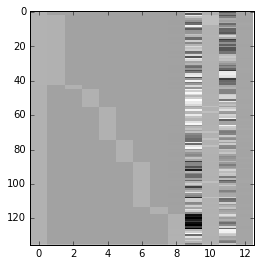

In [17]:
fig = plt.figure(figsize=(4,10))
ax = fig.add_subplot(111)
ax.imshow(glm_pheno, aspect=0.1, interpolation='None', cmap=plt.cm.Greys_r)

In [18]:
cov_weight = weight_store[..., cov_index.values]

In [19]:
res_store = list()
pval_store = np.zeros((scale, subtypes))
for net_id in range(scale):
    res_list = list()
    # Loop through the subtypes
    for s_id in range(subtypes):
        model = sm.OLS(cov_weight[net_id, s_id, :], glm_pheno)
        results = model.fit()
        # Save the p-values
        pval_store[net_id, s_id] = results.pvalues[cov]
        res_list.append(results)
    res_store.append(res_list)

# Look at the results

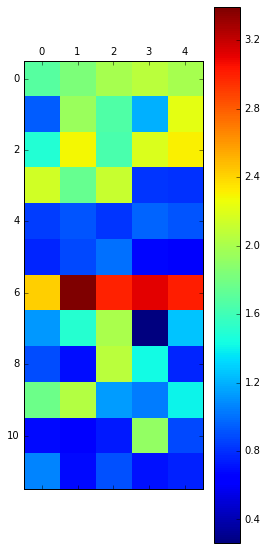

In [20]:
# Look at the uncorrected p-values for the GLM with diagnosis across networks
tmp = plt.matshow(-np.log10(pval_store))
tmp = plt.colorbar()

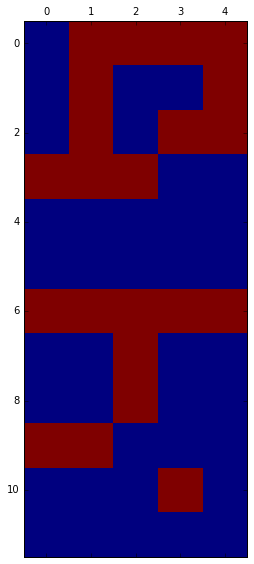

In [21]:
# Now look at the mask of p-values passing FDR Correction
pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
pcorr_vec = sts.multicomp.fdrcorrection0(pval_vec, 0.05)
pcorr_store = np.reshape(pcorr_vec[0], pval_store.shape)
tmp = plt.matshow(pcorr_store)

In [22]:
gdavg_img = nib.Nifti1Image(gdavg, affine=m_img.get_affine(), header=m_img.get_header())

In [23]:
def show_simple(net_id, sbt_id, gdavg_img, sbt_store, view_mode='x', threshold=0.1, 
                view_range=[-70,-50, -30, -10, 10, 30, 50, 70]):

    sbt = sbt_store[net_id, sbt_id,:]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt
    sbt_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    fig = plt.figure(figsize=(15,3))
    ax = fig.add_subplot(111)
    nlp.plot_stat_map(sbt_img, display_mode='x', threshold=threshold, 
                      cut_coords=view_range, black_bg=True,
                     axes=ax)
    return fig

In [24]:
view_range=[-70,-50, -30, -10, 10, 30, 50, 70]

## ADOS

### Network 1

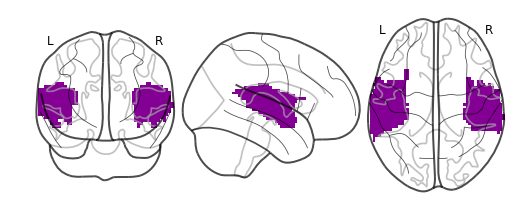

In [25]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 1), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

### pos

In [26]:
print(res_store[1][0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     5.734
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           8.69e-08
Time:                        18:43:12   Log-Likelihood:                 197.35
No. Observations:                 136   AIC:                            -368.7
Df Residuals:                     123   BIC:                            -330.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.7610      0.050     15.178      

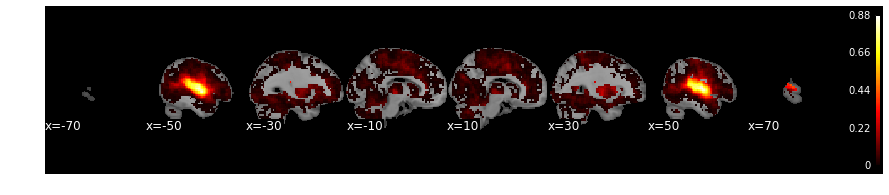

In [27]:
tmp = show_simple(1,0,gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

### neg

In [28]:
print(res_store[1][4].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     7.871
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           9.66e-11
Time:                        18:43:14   Log-Likelihood:                 180.03
No. Observations:                 136   AIC:                            -334.1
Df Residuals:                     123   BIC:                            -296.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.7955      0.057     13.969      

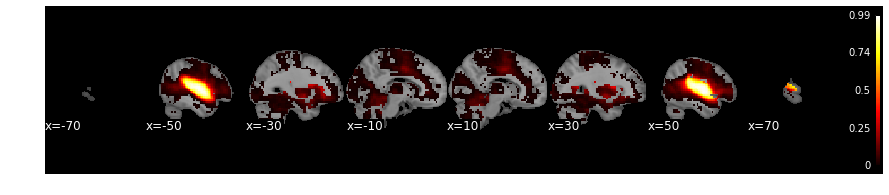

In [29]:
tmp = show_simple(1,4,gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

## Network 6

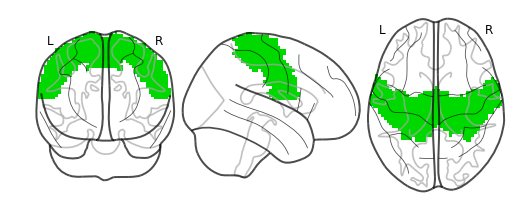

In [30]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 6), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

### neg

In [31]:
print(res_store[6][1].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     8.362
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           2.20e-11
Time:                        18:43:16   Log-Likelihood:                 178.32
No. Observations:                 136   AIC:                            -330.6
Df Residuals:                     123   BIC:                            -292.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.8409      0.058     14.580      

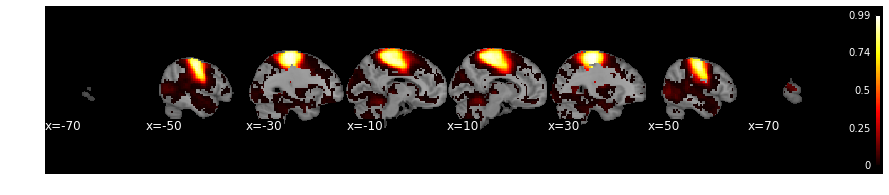

In [32]:
tmp = show_simple(6,1,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

### pos

In [33]:
print(res_store[6][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     8.321
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           2.48e-11
Time:                        18:43:17   Log-Likelihood:                 201.83
No. Observations:                 136   AIC:                            -377.7
Df Residuals:                     123   BIC:                            -339.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.8159      0.049     16.816      

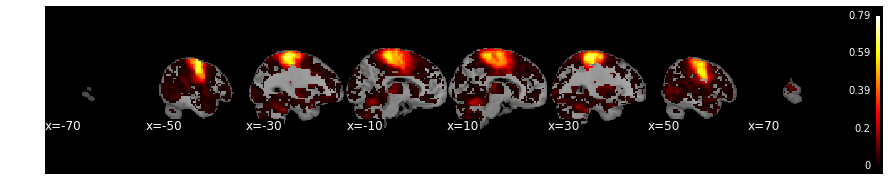

In [34]:
tmp = show_simple(6,2,gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [35]:
print(res_store[6][4].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     8.043
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           5.74e-11
Time:                        18:43:18   Log-Likelihood:                 186.47
No. Observations:                 136   AIC:                            -346.9
Df Residuals:                     123   BIC:                            -309.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.8339      0.054     15.353      

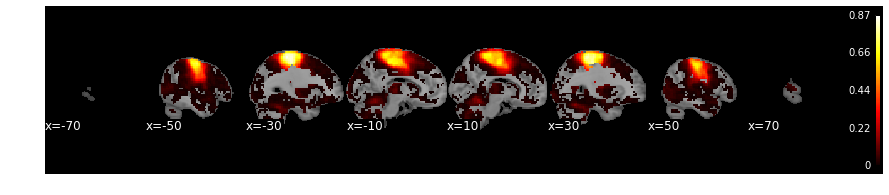

In [36]:
tmp = show_simple(6,4, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

### Network 7

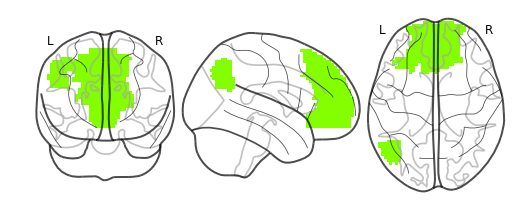

In [37]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 7), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

### neg

In [38]:
print(res_store[7][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     7.340
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           4.96e-10
Time:                        18:43:20   Log-Likelihood:                 176.49
No. Observations:                 136   AIC:                            -327.0
Df Residuals:                     123   BIC:                            -289.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.8267      0.058     14.144      

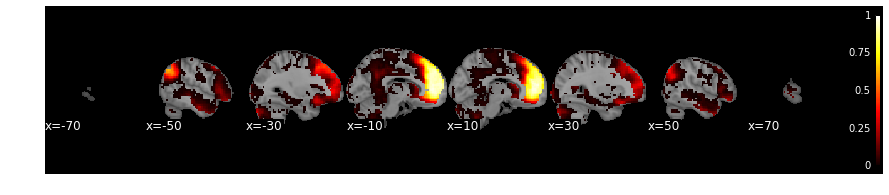

In [39]:
tmp = show_simple(7,2, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

### pos

In [40]:
print(res_store[7][3].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     6.593
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           5.27e-09
Time:                        18:43:21   Log-Likelihood:                 172.02
No. Observations:                 136   AIC:                            -318.0
Df Residuals:                     123   BIC:                            -280.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.7875      0.060     13.038      

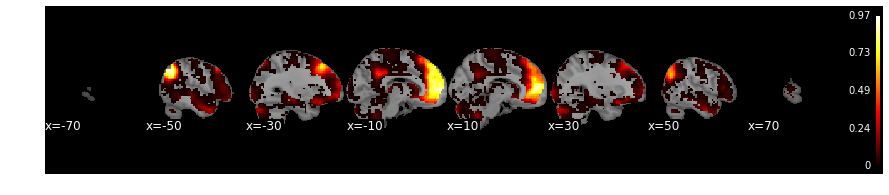

In [41]:
tmp = show_simple(7,3, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

# Look at diagnosis

DX_GROUP has 308


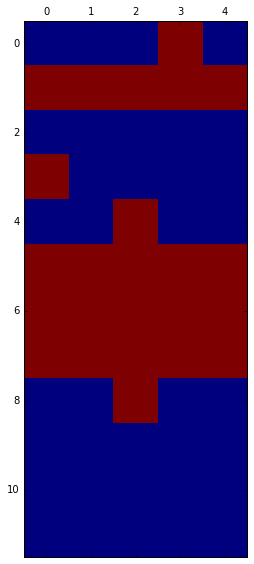

In [42]:
# Reduce the phenotype data to those subjects 
# that actually have the covariate of interest
cov_list = ['FIQ', 'VIQ', 'PIQ', 'ADI_R_SOCIAL_TOTAL_A',
            'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 
            'VINELAND_ABC_STANDARD', 'ADOS_TOTAL', 'SRS_RAW_TOTAL', 'DX_GROUP']
cov = cov_list[-1]
cov_index = pd.notnull(pheno.replace(-9999, np.nan)[cov])

print('{} has {}'.format(cov, np.sum(cov_index)))

cov_pheno = pheno[cov_index]
# Generate the model matrix
factors = [cov, 'SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
# Make dummy variables for the site factor
site_factor = pd.get_dummies(cov_pheno['SITE_ID'])
# Turn the first site into the intercept
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = cov_pheno.ix[:,factors]
# Turn diagnosis into [0,1] vector
#other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
# Demean age
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Demean the covariate
other_factors[cov] = other_factors[cov]-np.mean(other_factors[cov].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)

cov_weight = weight_store[..., cov_index.values]

res_store = list()
pval_store = np.zeros((scale, subtypes))
for net_id in range(scale):
    res_list = list()
    # Loop through the subtypes
    for s_id in range(subtypes):
        model = sm.OLS(cov_weight[net_id, s_id, :], glm_pheno)
        results = model.fit()
        # Save the p-values
        pval_store[net_id, s_id] = results.pvalues[cov]
        res_list.append(results)
    res_store.append(res_list)
    
# Now look at the mask of p-values passing FDR Correction
pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
pcorr_vec = sts.multicomp.fdrcorrection0(pval_vec, 0.05)
pcorr_store = np.reshape(pcorr_vec[0], pval_store.shape)
tmp = plt.matshow(pcorr_store)

## Network 0

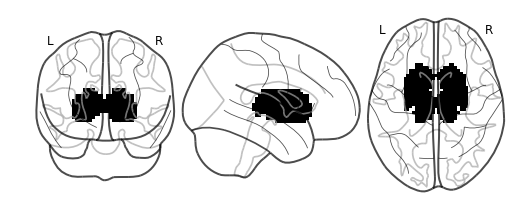

In [43]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 0), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

### neg (pos diag)

In [44]:
print(res_store[0][0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     12.44
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           1.22e-21
Time:                        18:43:24   Log-Likelihood:                 375.45
No. Observations:                 308   AIC:                            -722.9
Df Residuals:                     294   BIC:                            -670.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.9251      0.029     32.103      

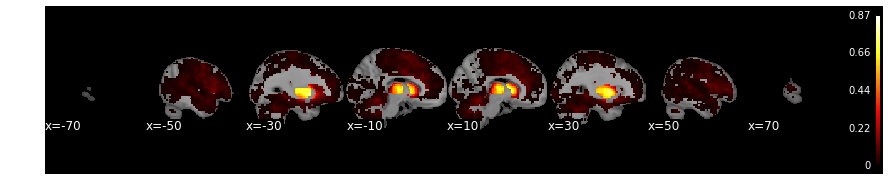

In [45]:
tmp = show_simple(0,0, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

### pos (neg diag)

In [46]:
print(res_store[0][3].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     14.42
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           6.20e-25
Time:                        18:43:25   Log-Likelihood:                 349.66
No. Observations:                 308   AIC:                            -671.3
Df Residuals:                     294   BIC:                            -619.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.9291      0.031     29.652      

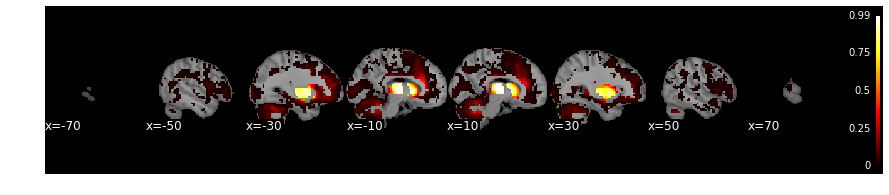

In [47]:
tmp = show_simple(0,3, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [48]:
print(res_store[0][4].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     16.04
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           1.62e-27
Time:                        18:43:26   Log-Likelihood:                 356.04
No. Observations:                 308   AIC:                            -684.1
Df Residuals:                     294   BIC:                            -631.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.9502      0.031     30.958      

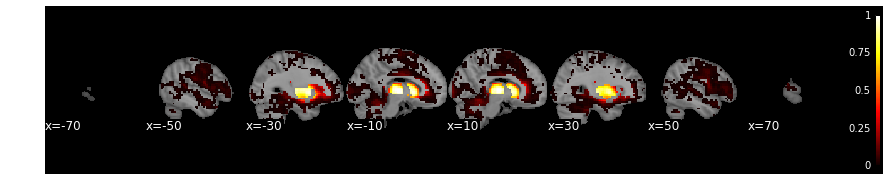

In [49]:
tmp = show_simple(0,4, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

## Network 4

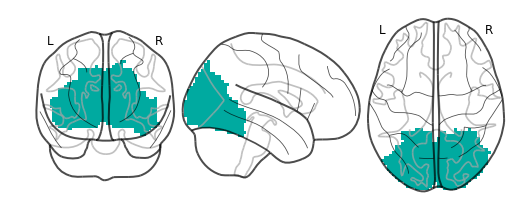

In [50]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 4), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

### pos (neg diag)

In [51]:
print(res_store[4][1].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     6.706
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           2.93e-11
Time:                        18:43:29   Log-Likelihood:                 419.03
No. Observations:                 308   AIC:                            -810.1
Df Residuals:                     294   BIC:                            -757.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.9437      0.025     37.725      

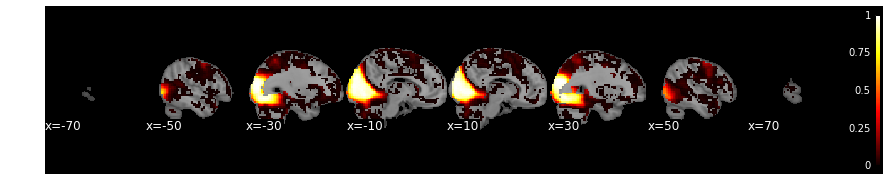

In [52]:
tmp = show_simple(4,1, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [53]:
print(res_store[4][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     9.131
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           8.43e-16
Time:                        18:43:30   Log-Likelihood:                 427.61
No. Observations:                 308   AIC:                            -827.2
Df Residuals:                     294   BIC:                            -775.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.9442      0.024     38.811      

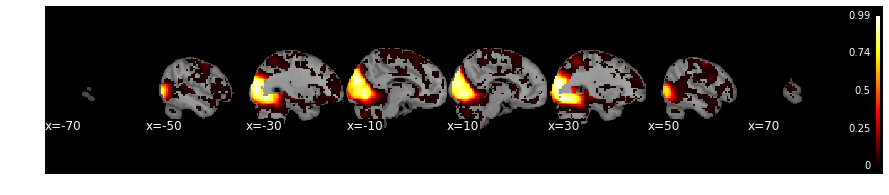

In [54]:
tmp = show_simple(4,2, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

### neg (pos diag)

In [55]:
print(res_store[4][3].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     3.742
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           1.51e-05
Time:                        18:43:31   Log-Likelihood:                 402.75
No. Observations:                 308   AIC:                            -777.5
Df Residuals:                     294   BIC:                            -725.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.8931      0.026     33.863      

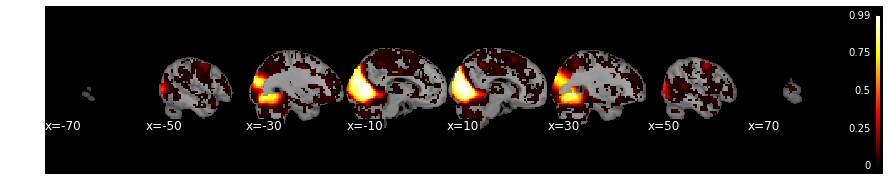

In [56]:
tmp = show_simple(4,3, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

## Network 6

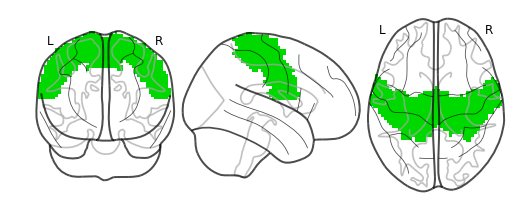

In [57]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 6), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

### pos (neg diag)

In [58]:
print(res_store[6][1].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     11.96
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           8.18e-21
Time:                        18:43:34   Log-Likelihood:                 370.80
No. Observations:                 308   AIC:                            -713.6
Df Residuals:                     294   BIC:                            -661.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.9450      0.029     32.301      

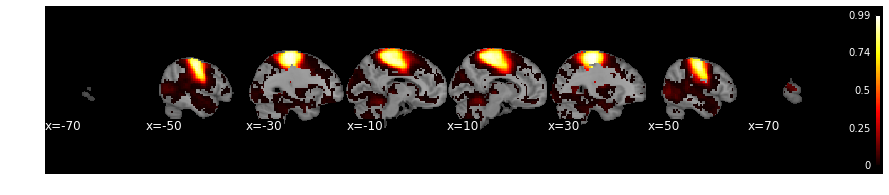

In [59]:
tmp = show_simple(6,1, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

### neg (pos diag)

In [60]:
print(res_store[6][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     11.29
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           1.15e-19
Time:                        18:43:35   Log-Likelihood:                 410.20
No. Observations:                 308   AIC:                            -792.4
Df Residuals:                     294   BIC:                            -740.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.8937      0.026     34.716      

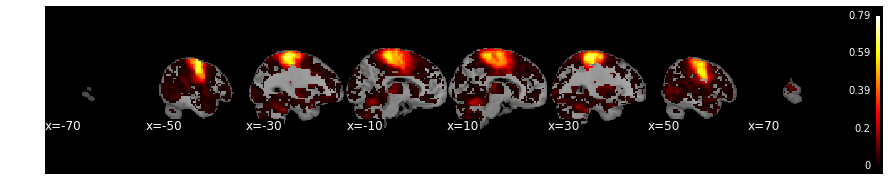

In [61]:
tmp = show_simple(6,2, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [62]:
print(res_store[6][4].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     10.73
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           1.12e-18
Time:                        18:43:36   Log-Likelihood:                 390.32
No. Observations:                 308   AIC:                            -752.6
Df Residuals:                     294   BIC:                            -700.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.9308      0.027     33.898      

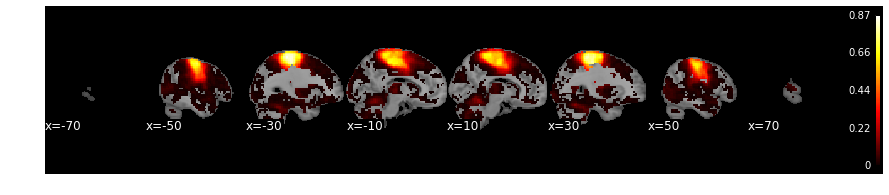

In [63]:
tmp = show_simple(6,4, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

# VIQ

VIQ has 276


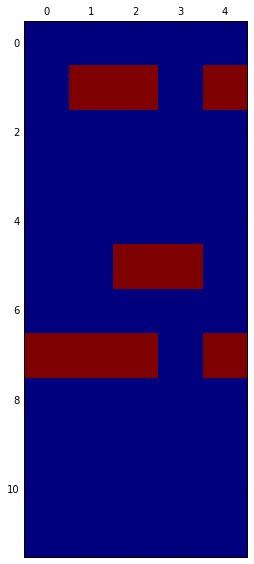

In [64]:
# Reduce the phenotype data to those subjects 
# that actually have the covariate of interest
cov_list = ['FIQ', 'VIQ', 'PIQ', 'ADI_R_SOCIAL_TOTAL_A',
            'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 
            'VINELAND_ABC_STANDARD', 'ADOS_TOTAL', 'SRS_RAW_TOTAL', 'DX_GROUP']
cov = cov_list[1]
cov_index = pd.notnull(pheno.replace(-9999, np.nan)[cov])

print('{} has {}'.format(cov, np.sum(cov_index)))

cov_pheno = pheno[cov_index]
# Generate the model matrix
factors = [cov, 'SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
# Make dummy variables for the site factor
site_factor = pd.get_dummies(cov_pheno['SITE_ID'])
# Turn the first site into the intercept
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = cov_pheno.ix[:,factors]
# Turn diagnosis into [0,1] vector
#other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
# Demean age
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Demean the covariate
other_factors[cov] = other_factors[cov]-np.mean(other_factors[cov].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)

cov_weight = weight_store[..., cov_index.values]

res_store = list()
pval_store = np.zeros((scale, subtypes))
for net_id in range(scale):
    res_list = list()
    # Loop through the subtypes
    for s_id in range(subtypes):
        model = sm.OLS(cov_weight[net_id, s_id, :], glm_pheno)
        results = model.fit()
        # Save the p-values
        pval_store[net_id, s_id] = results.pvalues[cov]
        res_list.append(results)
    res_store.append(res_list)
    
# Now look at the mask of p-values passing FDR Correction
pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
pcorr_vec = sts.multicomp.fdrcorrection0(pval_vec, 0.05)
pcorr_store = np.reshape(pcorr_vec[0], pval_store.shape)
tmp = plt.matshow(pcorr_store)

## Network 1

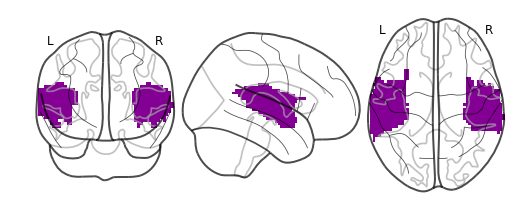

In [65]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 1), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

In [66]:
print(res_store[1][0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     8.498
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           5.22e-12
Time:                        18:43:38   Log-Likelihood:                 414.96
No. Observations:                 276   AIC:                            -807.9
Df Residuals:                     265   BIC:                            -768.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.8662      0.022     38.875      

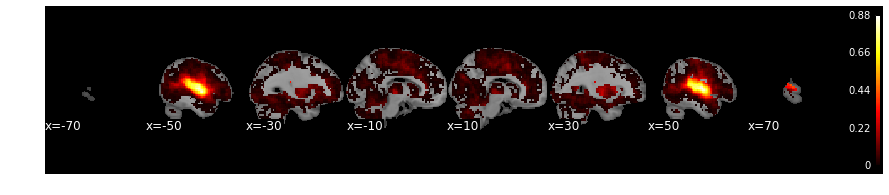

In [67]:
tmp = show_simple(1,0, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [68]:
print(res_store[1][4].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     13.81
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           1.47e-19
Time:                        18:43:40   Log-Likelihood:                 380.74
No. Observations:                 276   AIC:                            -739.5
Df Residuals:                     265   BIC:                            -699.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.9340      0.025     37.032      

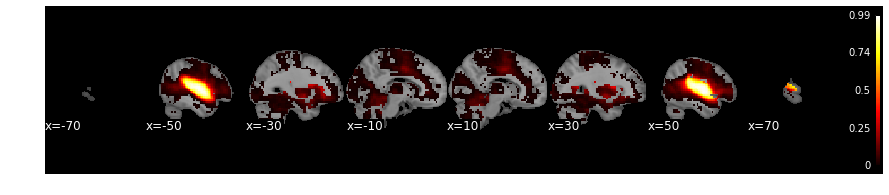

In [69]:
tmp = show_simple(1,4, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

## Network 6

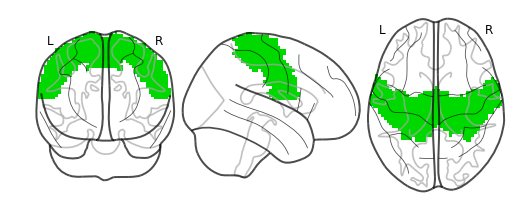

In [70]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 6), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

In [71]:
print(res_store[6][1].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     9.953
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           3.72e-14
Time:                        18:43:42   Log-Likelihood:                 331.10
No. Observations:                 276   AIC:                            -640.2
Df Residuals:                     265   BIC:                            -600.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.9481      0.030     31.403      

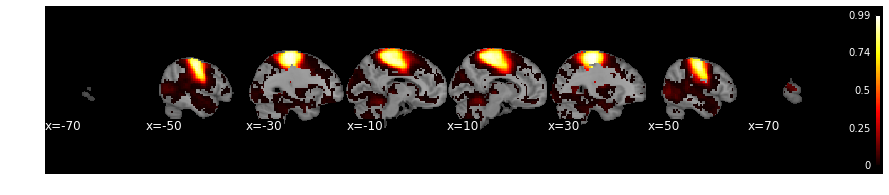

In [72]:
tmp = show_simple(6,1, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [73]:
print(res_store[6][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     10.27
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           1.28e-14
Time:                        18:43:43   Log-Likelihood:                 370.20
No. Observations:                 276   AIC:                            -718.4
Df Residuals:                     265   BIC:                            -678.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.8987      0.026     34.295      

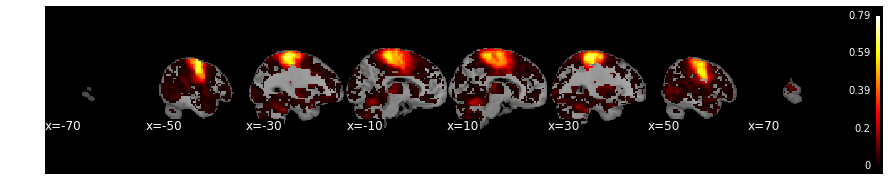

In [74]:
tmp = show_simple(6,2, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

## Network 7

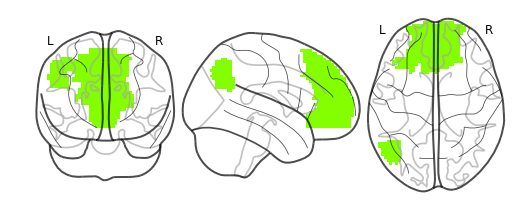

In [75]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 7), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

In [76]:
print(res_store[7][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     14.98
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           4.07e-21
Time:                        18:43:46   Log-Likelihood:                 371.31
No. Observations:                 276   AIC:                            -720.6
Df Residuals:                     265   BIC:                            -680.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.9041      0.026     34.639      

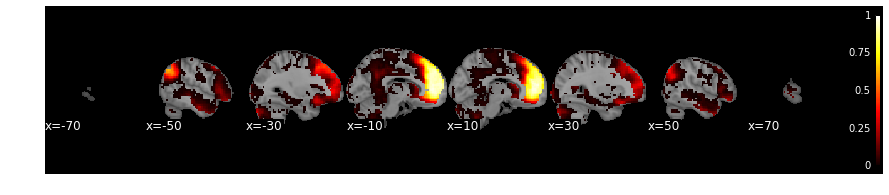

In [77]:
tmp = show_simple(7,2, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [78]:
print(res_store[7][3].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     10.15
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           1.93e-14
Time:                        18:43:47   Log-Likelihood:                 360.44
No. Observations:                 276   AIC:                            -698.9
Df Residuals:                     265   BIC:                            -659.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.8662      0.027     31.908      

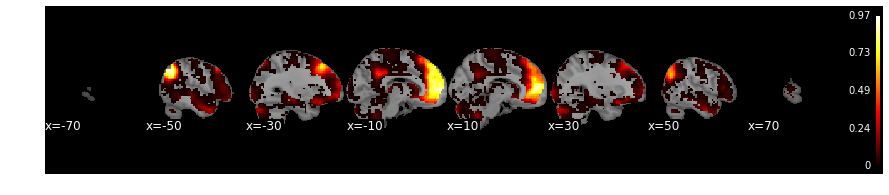

In [79]:
tmp = show_simple(7,3, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)